# Integrating Mouse and Human scRNA-seq Data with scVital

Welcome to this tutorial on integrating single-cell RNA sequencing (scRNA-seq) data from mouse and human samples using **scVital**. In recent years, scRNA-seq has revolutionized our understanding of cellular diversity and function by allowing us to profile gene expression at the single-cell level. However, integrating data from different species, such as mouse and human, poses unique challenges due to differences in gene expression profiles and biological contexts.

**scVital** is a powerful tool designed to address these challenges by providing robust methods for cross-species data integration. This tutorial will guide you through the process of using scVital to harmonize mouse and human scRNA-seq datasets, enabling comprehensive comparative analyses and insights into conserved and species-specific cellular processes.

## Objectives

By the end of this tutorial, you will be able to:
1. **Load preprocessed** mouse and human scRNA-seq datasets.
2. **Merge data for integration** appy to scVital.
3. **Apply scVital** to integrate these datasets.
4. **Visualize and interpret** the integrated data.
5. **Identify conserved and species-specific** cell populations and gene expression patterns.

## Prerequisites

To follow along with this tutorial, you should have:
- Basic knowledge of scRNA-seq data analysis.
- Familiarity with Python and Jupyter Notebooks.
- Installed the necessary Python packages, including scVital.

## Getting Started

Let's dive in and explore how scVital can help us bridge the gap between mouse and human scRNA-seq data, providing new insights into cellular biology across species.

# 1. Load Preproced Data

In this section, we will load the single-cell RNA sequencing (scRNA-seq) data for both mouse and human samples. We will use the `scanpy` library, which is a popular tool for analyzing single-cell data in Python.

In [ ]:
import numpy as np
import pandas as pd
import anndata as an
import scanpy as sc
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt

import torch
import warnings

import sys

sys.path.insert(0, '../src')
import scVital as sv

In [2]:
writeDir = "../data"
tissue = "muscle"

species1 = "human"
adataFile1 = f'{writeDir}/{tissue}Human_DeM_QC.h5ad'

species2 = "mouse"
adataFile2a = f'{writeDir}/{tissue}Mouse_QC.h5ad'
adataFile2b = f'{writeDir}/{tissue}Mouse_DeM_QC.h5ad'


## Read input files
read files into adata objects
these adata objects are just after quality control and not log-normalized

In [3]:
adata1 = sc.read_h5ad(adataFile1)

In [4]:
adata2 = sc.read_h5ad(adataFile2a)
adata3 = sc.read_h5ad(adataFile2b)

# Set up input adata for scVital integration
## Merge adatas

#### Function Purpose:
The `sv.mg.mergeAdatas` function merges multiple AnnData objects. This function can handle data from different species and infer homology information if not provided.

#### Parameters:
- `adatas`: A list of AnnData objects to be merged.
- `homology` (optional): A pandas DataFrame containing homology information between species. This is useful for aligning genes across different species.
- `species` (optional): A list of species corresponding to each AnnData object. This helps in identifying the origin of each dataset.
- `names` (optional): A list of names for each AnnData object. These names can be used for labeling and tracking the datasets.
- `label` (optional): A label for the concatenated AnnData object. The default value is "dataset".

#### Returns:
The function returns a single AnnData object that contains all the input AnnData objects merged together. This allows for integrated analysis of the combined data.


In [5]:
adata = sv.mg.mergeAdatas([adata1,  adata3]) #adata2,

/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:35: UserWarning: No species given, inferring them
  warnings.warn("No species given, inferring them")
/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:47: UserWarning: Species inferred: ['human', 'mouse']
  warnings.warn(f"Species inferred: {species}")
/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:50: UserWarning: No homology given, inferring them
  warnings.warn("No homology given, inferring them")
/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:67: UserWarning: Data not log normalized, calculating now
  warnings.warn("Data not log normalized, calculating now")
/Users/jonathanrub/Documents/school/cornell/scVital/vignettes/../src/scVital/merging.py:78: UserWarning: No names given, inferring them
  warnings.warn("No names given, inferring them")
/Users/jonathanrub/Documents/school/

## Find Highly Variable Genes
use normal scanpy workflow for highly variable gene selection

In [6]:
batchKey = "species"
sc.pp.highly_variable_genes(adata, batch_key=batchKey)

2019
802


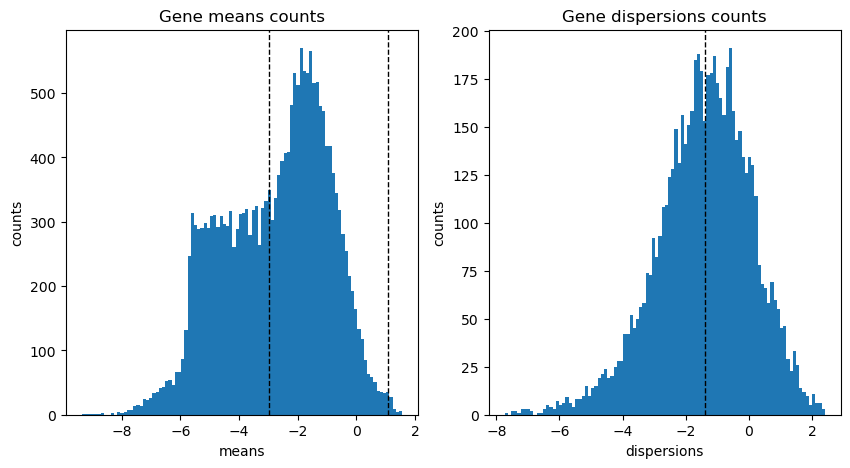

In [7]:
minMean = 0.05
maxMean = 2.9
minDisp = 0.25

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-8)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean, batch_key=batchKey)
print(sum(adata.var.highly_variable))
print(sum(adata.var.highly_variable_intersection))

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.raw = adata
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

# Integration with scVital 

### Run the scVital Model with the Specified Parameters

#### Parameters:
- `adata` (an.AnnData): Annotated data matrix.
- `batchLabel` (str): Label for batch processing.
- `miniBatchSize` (int, optional): Size of mini-batches for training. Default is 512.
- `numEpoch` (int, optional): Number of epochs for training. Default is 64.
- `learningRate` (float, optional): Learning rate for the optimizer. Default is 1e-3.
- `hid1` (int, optional): Number of units in the first hidden layer. Default is 1024.
- `hid2` (int, optional): Number of units in the second hidden layer. Default is 128.
- `latentSize` (int, optional): Size of the latent space. Default is 12.
- `discHid` (int, optional): Number of units in the discriminator hidden layer. Default is 6.
- `reconCoef` (float, optional): Coefficient for reconstruction loss. Default is 2e0.
- `klCoef` (float, optional): Coefficient for KL divergence loss. Default is 1e-1.
- `discCoef` (float, optional): Coefficient for discriminator loss. Default is 1e0.
- `discIter` (int, optional): Number of iterations for discriminator training. Default is 5.
- `earlyStop` (float, optional): Delta error to trigger early stopping. Default is 1e-2.
- `seed` (int, optional): Random seed for reproducibility. Default is 18.
- `verbose` (bool, optional): Flag for verbosity. Default is True.

In [9]:
setupData = {
    'adata': adata,
    'batchLabel': 'species',
    'miniBatchSize': 1024,
    'numEpoch': 50,
    'learningRate': 1e-3,
    'hid1': 1024,
    'hid2': 128,
    'latentSize': 12,
    'discHid': 6,
    'reconCoef': 2e0,
    'klCoef': 5e-2,
    'discCoef': 1e0,
    'discIter': 5,
    'earlyStop': 1e-2,
    'train': False,
    'seed': 18,
    'verbose': True
}

#### Returns:
- `scVital`: An instance of the scVital class initialized with the specified parameters.

#### Raises:
- `ValueError`: If any of the input parameters are invalid.

In [10]:
scVitalModel = sv.makeScVital(setupData['adata'], setupData['batchLabel'], setupData['miniBatchSize'], setupData['numEpoch'], setupData['learningRate'],
        setupData['hid1'], setupData['hid2'], setupData['latentSize'], setupData['discHid'], 
        setupData['reconCoef'], setupData['klCoef'], setupData['discCoef'], setupData['discIter'], 
        setupData['earlyStop'], setupData['train'], seed=setupData['seed'], verbose=setupData['verbose']
    )
print(scVitalModel)

Model Parameters:
adata: View of AnnData object with n_obs × n_vars = 25993 × 2019
    obs: 'sampleID', 'nFeature_RNA', 'nCount_RNA', 'percent_mito', 'cell_annotation', '10x_chemistry', 'cell_annotation.1', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'species', 'nUMI', 'nGene', 'injury', 'dataset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'hvg'
batchLabel: species
miniBatchSize: 1024
numEpoch: 50
learningRate: 0.001
reconCoef: 322.4468948524702
klCoef: 0.05
discCoef: 1.0
discIter: 5
earlyStop: 0.01
seed: 18
verbose: True
numSpeices: 2
layerDims: [2019, 1024, 128, 12]
inDiscriminatorDims: [12, 6]


## Run scVital

Train the scVital model, which includes an autoencoder and a discriminator, and store the results.

This function initializes the encoder, decoder, autoencoder, and discriminator. It sets up the optimizers and learning rate schedulers,
trains the models, and then stores the trained models and loss information. Finally, it prepares the data for evaluation and stores
the latent representations and reconstructed data in an AnnData object.

In [11]:
scVitalModel.runTrainScVital()

Epoch=0, batch=0, discr=0.7667, total=280.6794, recon=279.9033, trick=0.7761, klDiv=0.0000
Epoch=0, batch=8, discr=0.6272, total=149.4594, recon=148.7122, trick=0.7471, klDiv=0.0000
Epoch=0, batch=16, discr=0.5831, total=129.6678, recon=128.9008, trick=0.7670, klDiv=0.0000
Epoch=0, batch=24, discr=0.5574, total=121.1849, recon=120.3875, trick=0.7974, klDiv=0.0000
Epoch=10, batch=0, discr=0.3993, total=65.8716, recon=63.4473, trick=1.0972, klDiv=1.3271
Epoch=10, batch=8, discr=0.4089, total=65.3081, recon=62.8782, trick=1.0921, klDiv=1.3377
Epoch=10, batch=16, discr=0.4042, total=65.0451, recon=62.6097, trick=1.0906, klDiv=1.3448
Epoch=10, batch=24, discr=0.4068, total=64.9990, recon=62.5640, trick=1.0838, klDiv=1.3512
Epoch=20, batch=0, discr=0.3691, total=60.3628, recon=57.5859, trick=1.0846, klDiv=1.6923
Epoch=20, batch=8, discr=0.4006, total=60.5999, recon=57.8481, trick=1.0639, klDiv=1.6879
Epoch=20, batch=16, discr=0.4058, total=60.6394, recon=57.9013, trick=1.0581, klDiv=1.6800
E

TODO: implement loss dict plotting

In [12]:
print(scVitalModel)

Model Parameters:
adata: AnnData object with n_obs × n_vars = 25993 × 2019
    obs: 'sampleID', 'nFeature_RNA', 'nCount_RNA', 'percent_mito', 'cell_annotation', '10x_chemistry', 'cell_annotation.1', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'species', 'nUMI', 'nGene', 'injury', 'dataset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'hvg'
    obsm: 'X_scVital'
    layers: 'scVitalRecon'
batchLabel: species
miniBatchSize: 1024
numEpoch: 50
learningRate: 0.001
reconCoef: 322.4468948524702
klCoef: 0.05
discCoef: 1.0
discIter: 5
earlyStop: 0.01
seed: 18
verbose: True
numSpeices: 2
layerDims: [2019, 1024, 128, 12]
inDiscriminatorDims: [12, 6]


# Model Evaluation

In this section, we will evaluate the performance of our scVital model. Model evaluation is a crucial step in the analysis pipeline as it helps us understand how well our model has learned to integrate and represent the data. We will use several metrics and visualization techniques to assess the quality of the integration and the latent space representations.

### Objectives

By the end of this section, you will be able to:
1. **Identify clusters** and assess their biological relevance using marker genes.
2. **Visualize the integrated data** using UMAP.
3. **Evaluate the integration quality** using latent space similarity scores.
4. **Measure cluster concordance** using different metrics like the Adjusted Rand Index (ARI).

### Evaluation Metrics

We will use the following metrics to evaluate our model:
- **UMAP Visualization**: UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that helps visualize the high-dimensional data in a 2D space.
- **Cluster Identification by Marker Genes**: Identifying clusters and their corresponding marker genes helps in understanding the biological relevance of the clusters.
- **Latent Space Similarity Score**: This metric assesses how well the latent space representations from different species align with each other.
- **Adjusted Rand Index (ARI)**: ARI measures the similarity between the clusters identified by the model and the true labels, providing a quantitative measure of cluster concordance.

Let's proceed with the evaluation of our scVital model.



run standard scnapy workflow after integration

In [13]:
adata = scVitalModel.getAdata()

In [14]:
umapKey = "scVitalModel"
neighborsKey = "scVitalModel"
pcaRep = "X_scVital"

sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=scVitalModel.getLatentSize(), use_rep=pcaRep, key_added=umapKey)
sc.tl.umap(adata, neighbors_key = umapKey)
sc.tl.leiden(adata, resolution=0.1, key_added = neighborsKey, neighbors_key = umapKey)#, flavor="igraph", n_iterations=2,  directed=False)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-pac

UMAP visualization of scVital integration with clustering and annotation

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


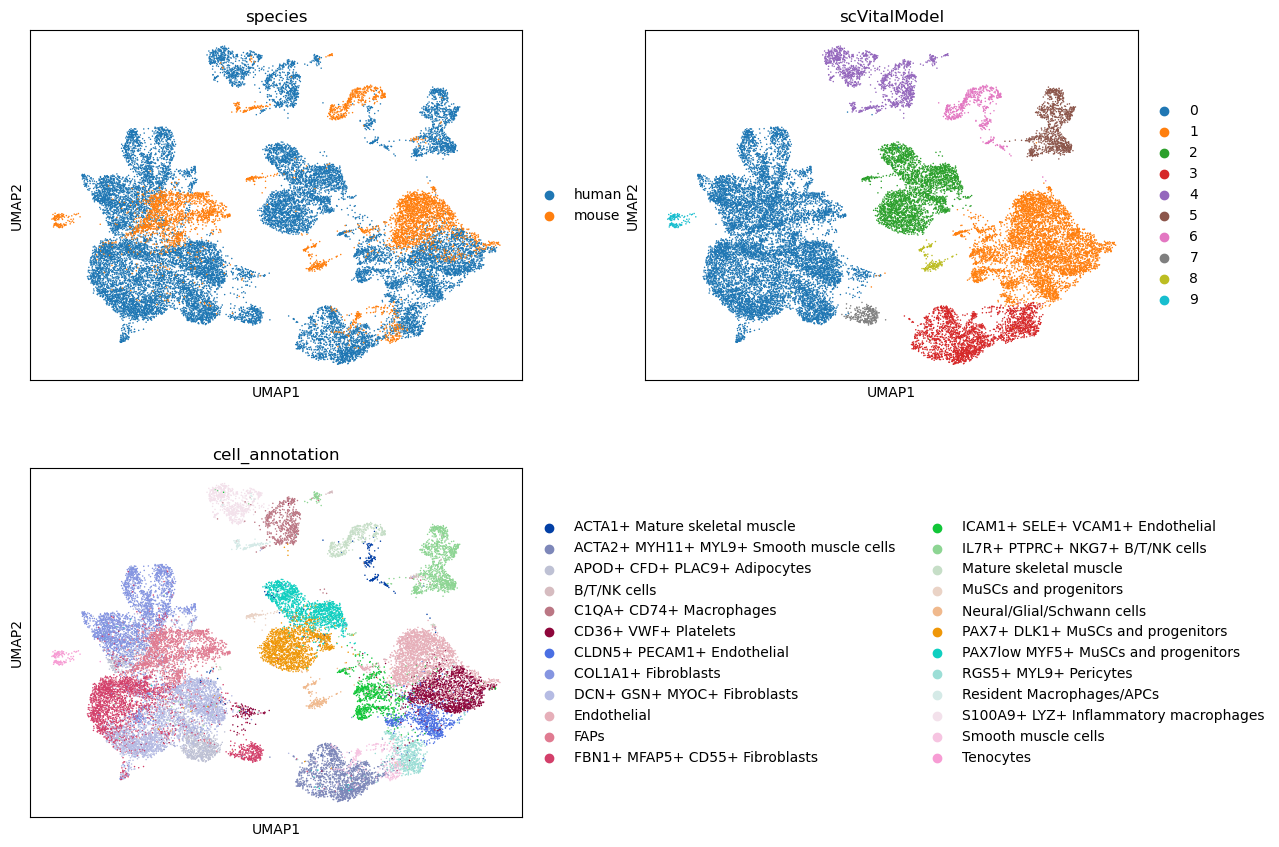

In [39]:
sc.pl.umap(adata, color = ["species",neighborsKey,"cell_annotation"], ncols = 2)

## Cell type annotation

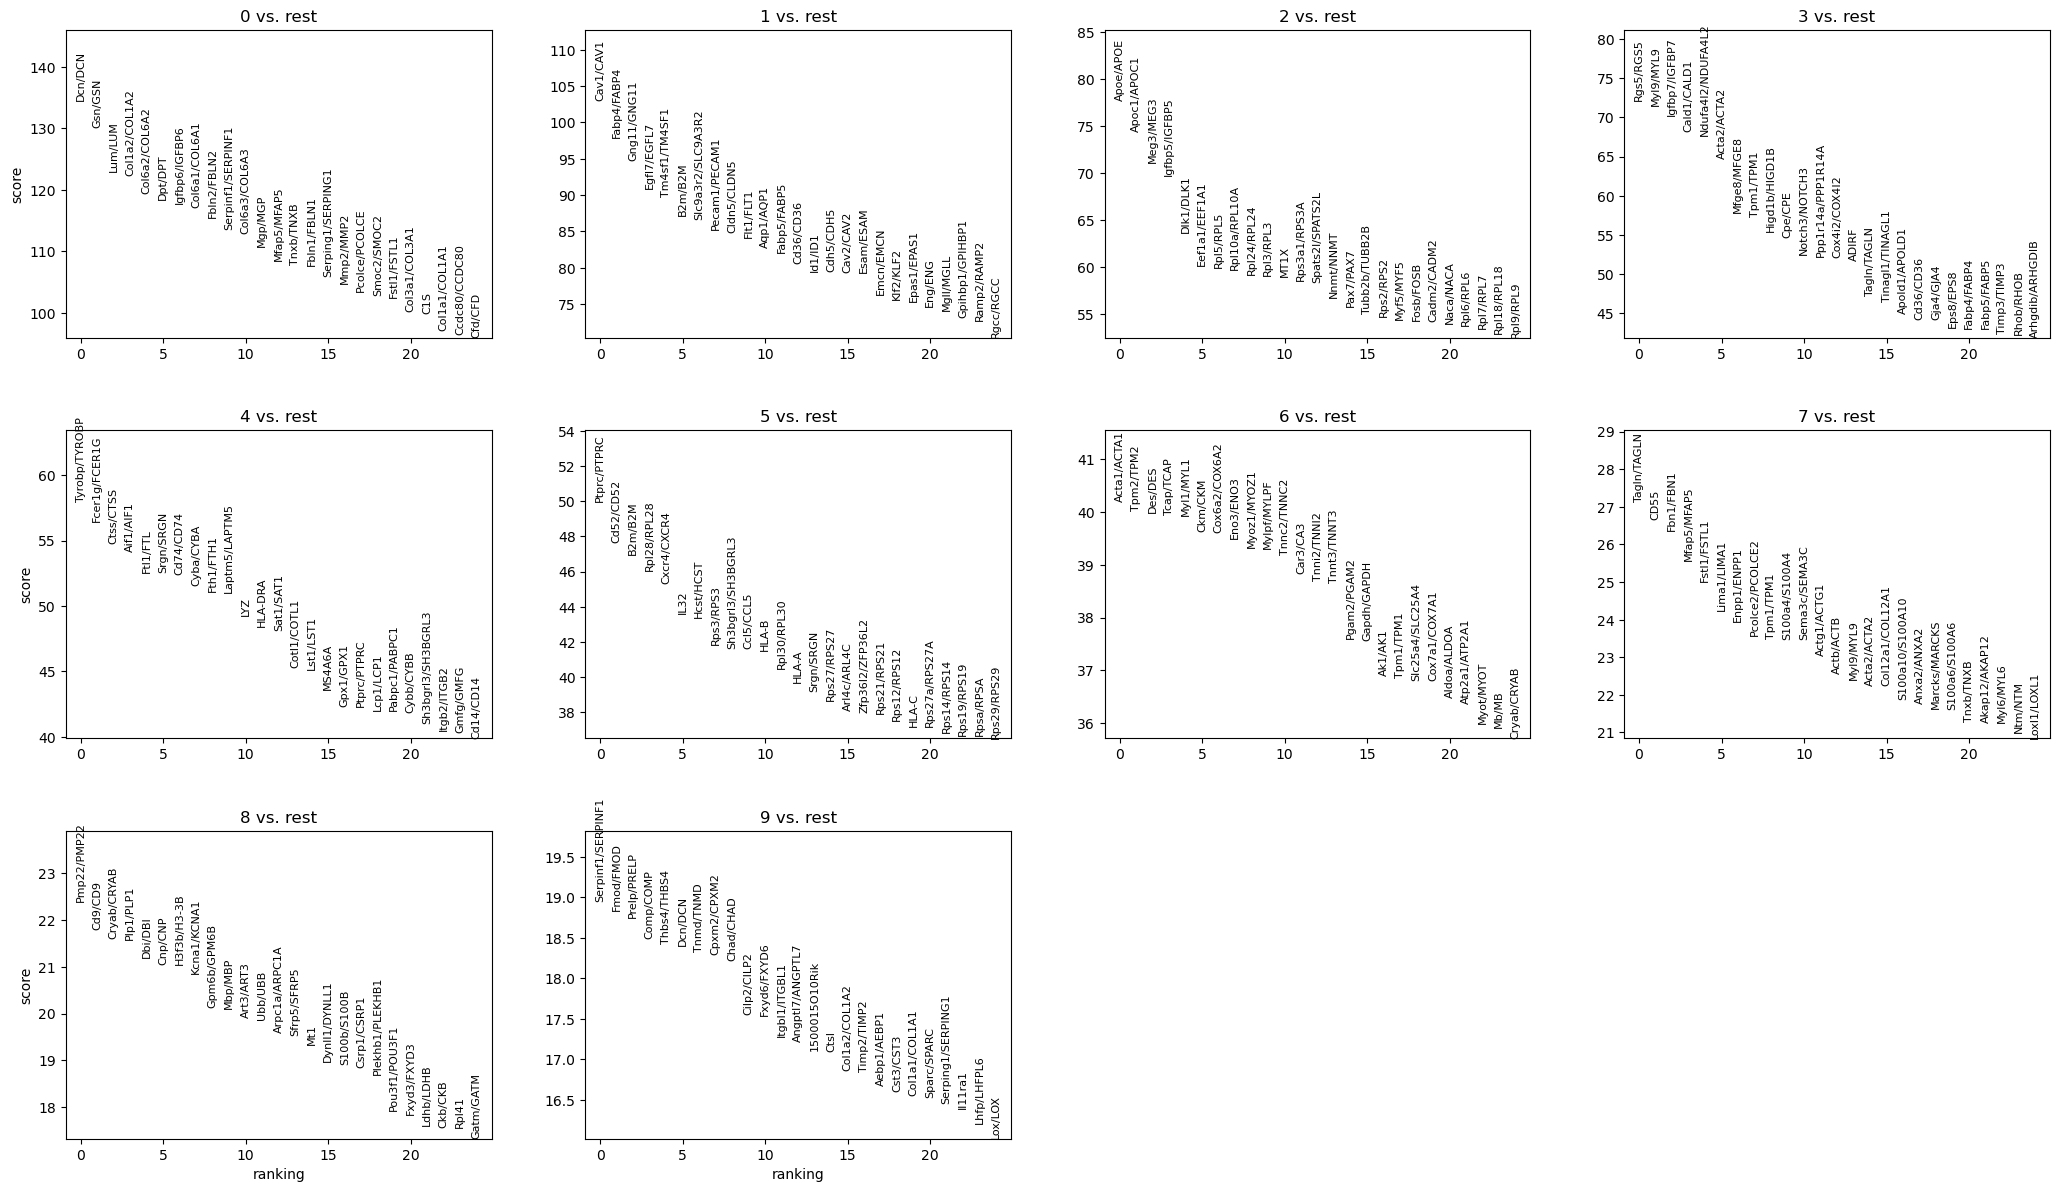

In [37]:
sc.tl.rank_genes_groups(adata, "scVitalModel", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [74]:
homology = pd.read_csv("../data/homology/MouseHumanHomology.csv")
homology

h2m = {homology.loc[hom,"human"]:homology.loc[hom,"mouse"] for hom in homology.index}
m2h = {homology.loc[hom,"mouse"]:homology.loc[hom,"human"] for hom in homology.index}

In [60]:
inMarkers = pd.read_csv("../data/humanMuscleDEG.csv", skiprows=1)
inMarkers

,gene,p_val,avg_logFC,pct.1,pct.2,cell type,surface marker?
0,FABP4,0.000000e+00,2.607364,0.944,0.256,Endothelial Cells,No
1,IFI27,0.000000e+00,2.309645,0.846,0.201,Endothelial Cells,No
2,CD74,2.380000e-304,1.889986,0.869,0.160,Endothelial Cells,Yes
3,RNASE1,7.340000e-285,2.491034,0.693,0.072,Endothelial Cells,No
4,B2M,2.190000e-279,1.096119,1.000,0.981,Endothelial Cells,Yes
...,...,...,...,...,...,...,...
2678,RPS24,7.342010e-03,0.420741,1.000,0.725,B Cells,No
2679,ERP29,7.563501e-03,0.633461,0.278,0.097,B Cells,No
2680,NOP10,7.784702e-03,0.399700,0.667,0.354,B Cells,No
2681,EIF4A2,8.571046e-03,0.429626,0.556,0.260,B Cells,No


In [94]:
geneLists = []
for ct in inMarkers["cell type"].unique():
    genes = inMarkers[inMarkers["cell type"]==ct]["gene"].values
    genes = [f"{h2m[g]}/{g}" if g in h2m.keys() else g for g in genes]
    genes = np.array([g if g in adata.var_names.values else None for g in genes])
    geneLists.append(genes)
    
muscleMark = pd.DataFrame(geneLists, inMarkers["cell type"].unique()).T
muscleMark

,Endothelial Cells,Pericytes,FAP Cells,Smooth Muscle Cells,PCV Endothelial Cells,Satellite Cells,NK Cells,FBN1+ FAP Cells,Myeloid Cells,T Cells,B Cells
0,None,Rgs5/RGS5,None,Rergl/RERGL,None,None,Ccl4/CCL4,Fbn1/FBN1,S100a8/S100A8,Cd3d/CD3D,None
1,IFI27,Ndufa4l2/NDUFA4L2,Lum/LUM,Myh11/MYH11,None,Apoe/APOE,Nkg7/NKG7,Prg4/PRG4,LYZ,Il7r/IL7R,None
2,Cd74/CD74,Higd1b/HIGD1B,None,Pln/PLN,Plvap/PLVAP,Myf5/MYF5,GNLY,Pcolce2/PCOLCE2,Aif1/AIF1,Ltb/LTB,None
3,Rnase1/RNASE1,Abcc9/ABCC9,ADH1B,Casq2/CASQ2,Plat/PLAT,Trdn/TRDN,Gzma/GZMA,LINC01133,S100a9/S100A9,Cd52/CD52,None
4,None,Notch3/NOTCH3,Myoc/MYOC,Actg2/ACTG2,HLA-DQA1,Myf6/MYF6,Ccl3/CCL3,Mfap5/MFAP5,Lst1/LST1,Cd3e/CD3E,Cd79a/CD79A
...,...,...,...,...,...,...,...,...,...,...,...
445,None,None,None,None,None,None,None,None,None,None,None
446,None,None,None,None,None,None,None,None,None,None,None
447,None,None,None,None,None,None,None,None,None,None,None
448,None,None,None,None,None,None,None,None,None,None,None


In [99]:
markerDict = {ct:muscleMark.iloc[0:5,i].dropna().values for i,ct in enumerate(muscleMark.columns)} 
markerDict

{'Endothelial Cells': array(['IFI27', 'Cd74/CD74', 'Rnase1/RNASE1'], dtype=object),
 'Pericytes': array(['Rgs5/RGS5', 'Ndufa4l2/NDUFA4L2', 'Higd1b/HIGD1B', 'Abcc9/ABCC9',
        'Notch3/NOTCH3'], dtype=object),
 'FAP Cells': array(['Lum/LUM', 'ADH1B', 'Myoc/MYOC'], dtype=object),
 'Smooth Muscle Cells': array(['Rergl/RERGL', 'Myh11/MYH11', 'Pln/PLN', 'Casq2/CASQ2',
        'Actg2/ACTG2'], dtype=object),
 'PCV Endothelial Cells': array(['Plvap/PLVAP', 'Plat/PLAT', 'HLA-DQA1'], dtype=object),
 'Satellite Cells': array(['Apoe/APOE', 'Myf5/MYF5', 'Trdn/TRDN', 'Myf6/MYF6'], dtype=object),
 'NK Cells': array(['Ccl4/CCL4', 'Nkg7/NKG7', 'GNLY', 'Gzma/GZMA', 'Ccl3/CCL3'],
       dtype=object),
 'FBN1+ FAP Cells': array(['Fbn1/FBN1', 'Prg4/PRG4', 'Pcolce2/PCOLCE2', 'LINC01133',
        'Mfap5/MFAP5'], dtype=object),
 'Myeloid Cells': array(['S100a8/S100A8', 'LYZ', 'Aif1/AIF1', 'S100a9/S100A9', 'Lst1/LST1'],
       dtype=object),
 'T Cells': array(['Cd3d/CD3D', 'Il7r/IL7R', 'Ltb/LTB', 'Cd52/CD52

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


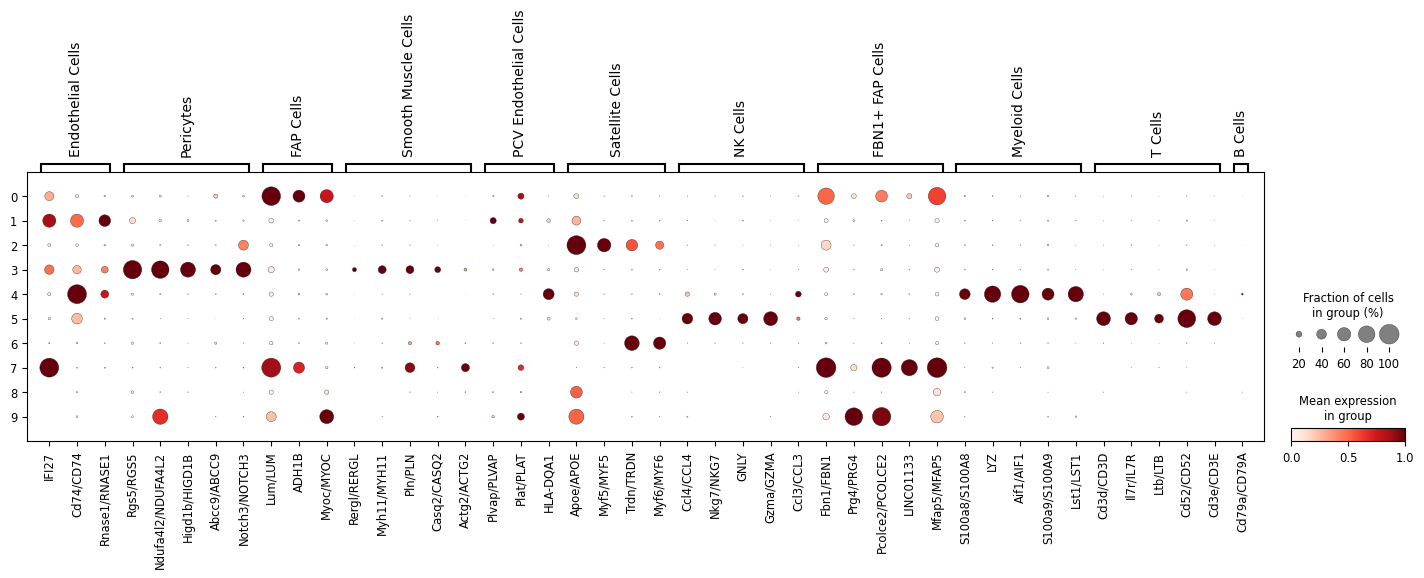

In [123]:
sc.pl.dotplot(adata, markerDict, groupby="scVitalModel", standard_scale="var")

In [108]:
rankGenes = pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(400)
rankGenes

,0,1,2,3,4,5,6,7,8,9
0,Dcn/DCN,Cav1/CAV1,Apoe/APOE,Rgs5/RGS5,Tyrobp/TYROBP,Ptprc/PTPRC,Acta1/ACTA1,Tagln/TAGLN,Pmp22/PMP22,Serpinf1/SERPINF1
1,Gsn/GSN,Fabp4/FABP4,Apoc1/APOC1,Myl9/MYL9,Fcer1g/FCER1G,Cd52/CD52,Tpm2/TPM2,CD55,Cd9/CD9,Fmod/FMOD
2,Lum/LUM,Gng11/GNG11,Meg3/MEG3,Igfbp7/IGFBP7,Ctss/CTSS,B2m/B2M,Des/DES,Fbn1/FBN1,Cryab/CRYAB,Prelp/PRELP
3,Col1a2/COL1A2,Egfl7/EGFL7,Igfbp5/IGFBP5,Cald1/CALD1,Aif1/AIF1,Rpl28/RPL28,Tcap/TCAP,Mfap5/MFAP5,Plp1/PLP1,Comp/COMP
4,Col6a2/COL6A2,Tm4sf1/TM4SF1,Dlk1/DLK1,Ndufa4l2/NDUFA4L2,Ftl1/FTL,Cxcr4/CXCR4,Myl1/MYL1,Fstl1/FSTL1,Dbi/DBI,Thbs4/THBS4
...,...,...,...,...,...,...,...,...,...,...
395,Kdelr3/KDELR3,Psme2/PSME2,Frmd3/FRMD3,Rasd1/RASD1,CLEC4A,WHSC1L1,Smim11/SMIM11,Ablim1/ABLIM1,Sptssa/SPTSSA,Ahnak2/AHNAK2
396,Gfra1/GFRA1,Dach1/DACH1,Taf1d/TAF1D,GSTP1,HLA-A,CD99,Mrpl33/MRPL33,Ntn4/NTN4,Clstn1/CLSTN1,Ifi27
397,Atp6v0e/ATP6V0E1,Plpp1/PLPP1,Sun2/SUN2,Naca/NACA,Vmp1/VMP1,Ankrd11/ANKRD11,Ppp1r14c/PPP1R14C,Rala/RALA,Etfb/ETFB,Gm9844
398,Cks1b/CKS1B,Hif3a/HIF3A,Vav3/VAV3,Fxyd1/FXYD1,RP5-1171I10.5,Tagap1/TAGAP,Tmem65/TMEM65,Cp/CP,Psmb2/PSMB2,Spcs1/SPCS1


In [122]:
confMatrix = pd.DataFrame(np.zeros((len(rankGenes.columns), len(muscleMark.columns))), index=rankGenes.columns, columns=muscleMark.columns)
for l in rankGenes:
    for ct in muscleMark:
        confMatrix.loc[l,ct] = len(set(rankGenes[l].values).intersection(set(muscleMark[ct].values)))
        
confMatrix

,Endothelial Cells,Pericytes,FAP Cells,Smooth Muscle Cells,PCV Endothelial Cells,Satellite Cells,NK Cells,FBN1+ FAP Cells,Myeloid Cells,T Cells,B Cells
0,3.0,13.0,68.0,12.0,2.0,6.0,3.0,79.0,5.0,0.0,0.0
1,69.0,14.0,1.0,13.0,55.0,4.0,6.0,0.0,8.0,4.0,5.0
2,1.0,7.0,5.0,17.0,4.0,40.0,2.0,8.0,9.0,3.0,3.0
3,23.0,55.0,1.0,73.0,16.0,18.0,4.0,7.0,8.0,3.0,2.0
4,10.0,3.0,4.0,2.0,14.0,2.0,28.0,4.0,92.0,14.0,30.0
5,7.0,4.0,2.0,4.0,6.0,3.0,55.0,2.0,32.0,30.0,19.0
6,1.0,8.0,1.0,16.0,2.0,12.0,0.0,5.0,3.0,0.0,0.0
7,3.0,13.0,34.0,18.0,3.0,5.0,3.0,62.0,6.0,0.0,0.0
8,1.0,8.0,2.0,12.0,4.0,9.0,3.0,5.0,8.0,2.0,0.0
9,1.0,8.0,17.0,11.0,2.0,5.0,0.0,29.0,5.0,1.0,0.0


## Run latent space similarity (LSS)
set up similar pairs for LSS evaluation when cell types are known

In [17]:
adata.uns["pairs"] = [['ACTA1+ Mature skeletal muscle','Mature skeletal muscle'],
['ACTA2+ MYH11+ MYL9+ Smooth muscle cells','Smooth muscle cells'],
['IL7R+ PTPRC+ NKG7+ B/T/NK cells', 'B/T/NK cells'],
['APOD+ CFD+ PLAC9+ Adipocytes', 'FAPs'],
['COL1A1+ Fibroblasts','FAPs'],
['DCN+ GSN+ MYOC+ Fibroblasts', 'FAPs'],
['FBN1+ MFAP5+ CD55+ Fibroblasts', 'FAPs'],
['RGS5+ MYL9+ Pericytes',  'Endothelial'],
['CD36+ VWF+ Platelets',  'Endothelial'],
['CLDN5+ PECAM1+ Endothelial', 'Endothelial'],
['ICAM1+ SELE+ VCAM1+ Endothelial','Endothelial'],
['PAX7+ DLK1+ MuSCs and progenitors','MuSCs and progenitors'],
['PAX7low MYF5+ MuSCs and progenitors', 'MuSCs and progenitors'],
['C1QA+ CD74+ Macrophages', 'Resident Macrophages/APCs'],
['S100A9+ LYZ+ Inflammatory macrophages','Resident Macrophages/APCs']]

In [19]:
cellTypeLabel="cell_annotation"
latent="X_scVital"
batchName="species"

clustDist, lssAUC, totalDist, allCellTypes, ctPairs = sv.lss.calcPairsLSS(adata, latent=latent, batchName=batchName, cellTypeLabel=cellTypeLabel)
print(lssAUC)

0.9849673202614379


create LSS graph

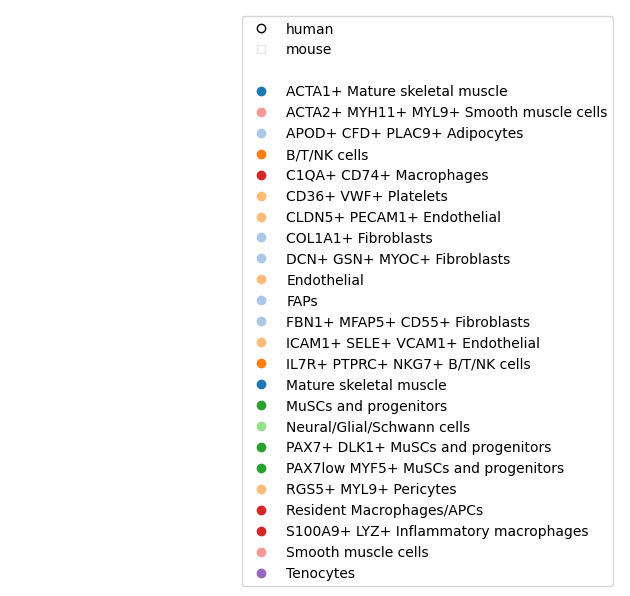

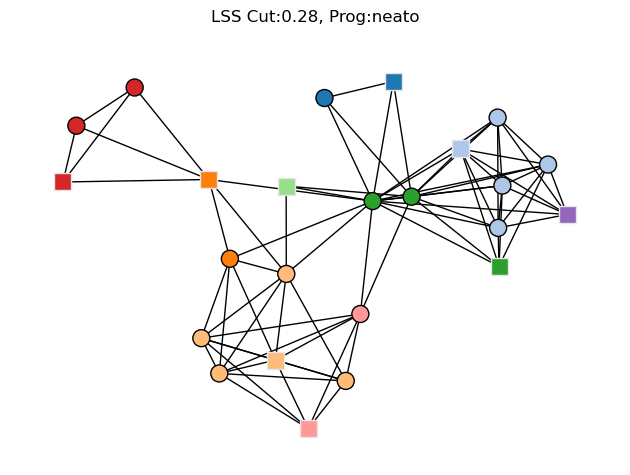

In [20]:
#
batchDict, annoToColorDict = sv.lss.plotGraphLSS(adata, cellTypeLabel, batchName, clustDist, name="muscleTest", 
             ctColors=plt.get_cmap('tab20').colors, btColors=None, shapes="ospx^><.....", 
             prog="neato", wLab=False, qCut = 0.28, plot=True, save=False)

create Heatmap of LSS

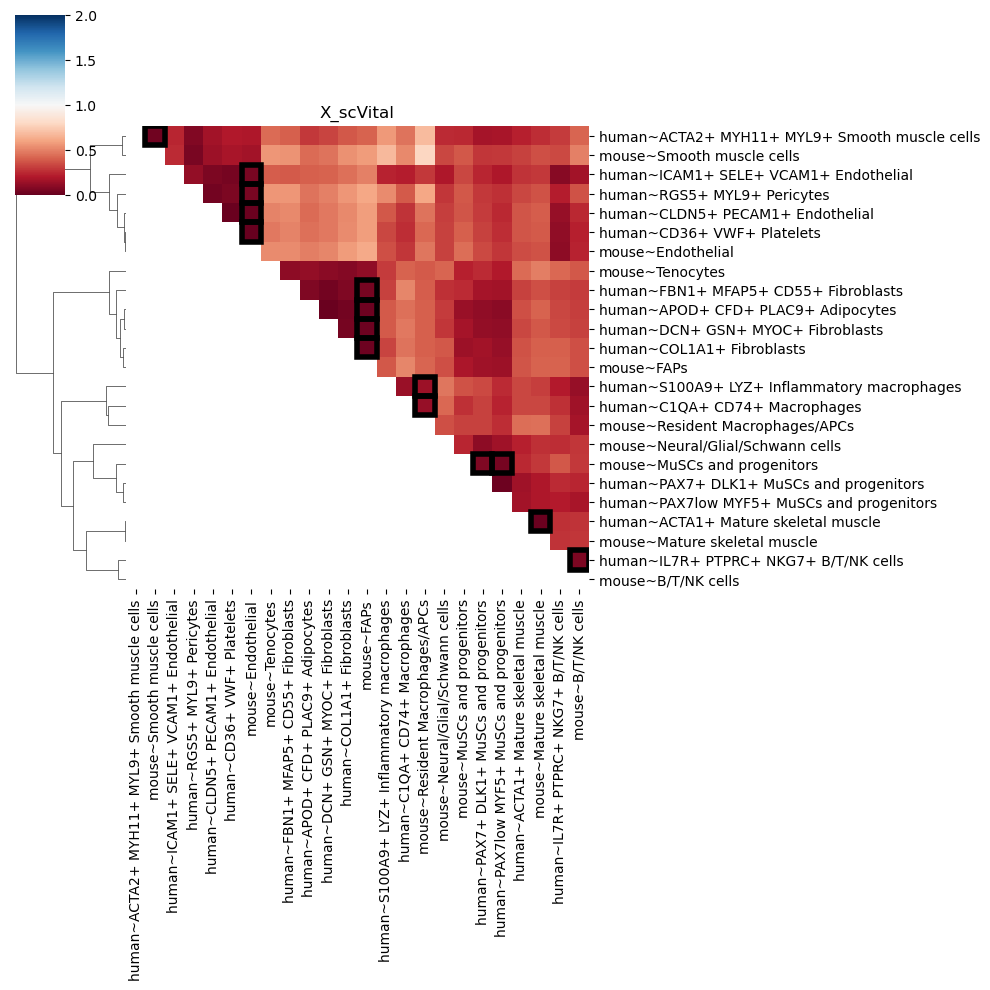

In [21]:
sv.lss.plotHeatLSS(adata, clustDist, latent, allCellTypes, ctPairs, save=False, plot=True)

## Other common clustering evaluations

In [22]:
from sklearn import metrics
def getClusterMetricDF(labels_true, labels, neighborsKey):
    metricDict = {'Homog': metrics.homogeneity_score,
                  'Compl': metrics.completeness_score,
                  'V-meas': metrics.v_measure_score,
                  'FM': metrics.fowlkes_mallows_score,
                  'ARI': metrics.adjusted_rand_score,
                  'AMI': metrics.adjusted_mutual_info_score
                  }
    metricOut = [f"{metricDict[metricF](labels_true, labels):0.3}" for metricF in metricDict]
    metricDF = pd.DataFrame(metricOut, columns=[neighborsKey], index=list(metricDict.keys()))
    return(metricDF.T)

getClusterMetricDF(adata.obs.anno, adata.obs.scVitalModel, "scVital")

,Homog,Compl,V-meas,FM,ARI,AMI
scVital,0.889,0.901,0.895,0.946,0.927,0.894


commented with the help of copilot

make simpler annoations for vizualization 

In [15]:
annoDict = {'ICAM1+ SELE+ VCAM1+ Endothelial': "Endo",
 'CLDN5+ PECAM1+ Endothelial': "Endo",
 'RGS5+ MYL9+ Pericytes': "Peri",
 'APOD+ CFD+ PLAC9+ Adipocytes': "Fibro",
 'PAX7low MYF5+ MuSCs and progenitors': "MuSCs",
 'ACTA2+ MYH11+ MYL9+ Smooth muscle cells': "smooth",
 'C1QA+ CD74+ Macrophages': "Macro",
 'IL7R+ PTPRC+ NKG7+ B/T/NK cells': "Imm",
 'COL1A1+ Fibroblasts': "Fibro",
 'CD36+ VWF+ Platelets': "Endo",
 'FBN1+ MFAP5+ CD55+ Fibroblasts': "Fibro",
 'ACTA1+ Mature skeletal muscle': "skel",
 'DCN+ GSN+ MYOC+ Fibroblasts': "Fibro",
 'S100A9+ LYZ+ Inflammatory macrophages': "Macro",
 'PAX7+ DLK1+ MuSCs and progenitors': "MuSCs",
 #'HBA1+ Erythroblasts':  "eryth",
 #nan: 4287,
 'MuSCs and progenitors': "MuSCs",
 'Endothelial': "Endo",
 'Mature skeletal muscle': "skel",
 'Neural/Glial/Schwann cells': "neural",
 'FAPs': "Fibro",
 'Smooth muscle cells': "smooth",
 'Resident Macrophages/APCs': "Macro",
 'Tenocytes': "teno",
 'B/T/NK cells': "Imm"}
adata = adata[adata.obs["cell_annotation"] != "HBA1+ Erythroblasts"]
adata.obs["anno"]=pd.Categorical([ct if pd.isna(ct) else annoDict[ct] for ct in adata.obs["cell_annotation"]])

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_51011/1647637988.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["anno"]=pd.Categorical([ct if pd.isna(ct) else annoDict[ct] for ct in adata.obs["cell_annotation"]])
